<a href="https://colab.research.google.com/github/rolandoteniya/austin-airbnb-spatial-analysis/blob/main/Austin_Airbnb_Geodemographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction: The Spatial Economy of Short-Term Rentals in Austin
This computational essay analyses the Airbnb market as well as other interesting aspects of Austin, Texas. Austin provides a unique case study due to its rapid tech-driven gentrification ("Silicon Hills") and distinct historical economic segregation. The analysis aims to determine whether short-term rentals cluster randomly or if they systematically target specific neighborhood typologies—specifically those with high "lifestyle" amenities..

### Data Sourcing & Preparation
The primary dataset consists of Airbnb listings sourced from *Inside Airbnb* (September 2023). To ensure robustness, the data was cleaned to remove inactive listings and price outliers (>$2,000/night). Crucially, the spatial data was reprojected to **EPSG:2277 (NAD83 / Texas Central)**. This projection is essential for accurate distance-based spatial analysis (such as K-Means clustering) as it minimizes distortion specifically for the Central Texas region.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q osmnx
!pip install -q contextily
!pip install -q rasterstats
!pip install -q rasterio
!pip install -q cenpy
!pip install -q census
!pip install -q us
!pip install -q censusdata

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mapclassify
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from libpysal import weights
from esda.moran import Moran, Moran_Local
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import osmnx as ox
import cenpy
import libpysal
from splot.esda import lisa_cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
#1.1 Collecting and importing the data
#load the data
listings = pd.read_csv('/content/drive/MyDrive/Data Science and AI/ENVS563/assignments/assignment 2 new/listings.csv')
print(f"Airbnb Raw Data: {listings.shape[0]} rows, {listings.shape[1]} columns")

listings_gdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'], listings['latitude']),
    crs="EPSG:4326"
)

zip_path = '/content/drive/MyDrive/Data Science and AI/ENVS563/assignments/assignment 2 new/tl_2020_us_zcta520.shp'
austin_zips = gpd.read_file(zip_path)

# filtering the boundaries data with prefix zipcode 787
austin_focus = austin_zips[austin_zips['ZCTA5CE20'].astype(str).str.startswith('787')].copy()

Airbnb Raw Data: 15187 rows, 79 columns


In [ ]:
#1.2 preparing the data

# Converting to EPSG:2277 from EPSG:2277 as to make for accurate distance measuring. EPSG:2277 is the standard for Austin, Texas projections
target_crs = "EPSG:2277"

austin_focus = austin_focus.to_crs(target_crs)
listings_gdf = listings_gdf.to_crs(target_crs)

#spatial filtering
# This removes any stray points that might be near Austin but not in our study area.
listings_austin = gpd.sjoin(listings_gdf, austin_focus, how="inner", predicate="within")

print(f"Listings before clip: {listings_gdf.shape[0]}")
print(f"Listings after clip (inside Austin 787xx): {listings_austin.shape[0]}")

# cleaning price data
# Removing '$' and ',' signs and converting to float
listings_austin['price_clean'] = listings_austin['price'].replace('[\$,]', '', regex=True).astype(float)

#removing outliers. removing any listings with no prices, any listings less than 1$/night and any listings more than 2000$/night to avoid affecting the analysis.
listings_clean = listings_austin[
    (listings_austin['price_clean'] > 1) &
    (listings_austin['price_clean'] < 2000)
].copy()

print(f"Listings after price cleaning: {listings_clean.shape[0]}")

# visualising data
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# austin_focus.plot(ax=ax, color='lightgrey', edgecolor='white')
# listings_clean.plot(ax=ax, column='price_clean', markersize=2, cmap='viridis', alpha=0.6, legend=True)
# plt.title("Cleaned Austin Airbnb Data (Projected EPSG:2277)")
# plt.show()

Listings before clip: 15187
Listings after clip (inside Austin 787xx): 15182
Listings after price cleaning: 10572


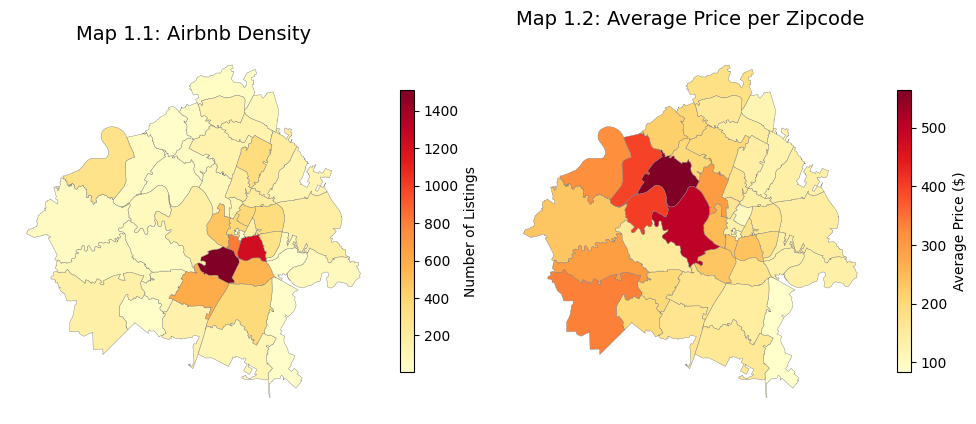

In [ ]:

# Calculating listing count and average price per zipcode
zip_data = listings_clean.groupby('ZCTA5CE20').agg(
    listing_count=('id', 'count'),
    avg_price=('price_clean', 'mean')
).reset_index()

austin_map_data = austin_focus.merge(zip_data, on='ZCTA5CE20', how='left')

fig, axes = plt.subplots(1, 2, figsize=(10,5))

# MAP 1.1: Listing Count (Density)
austin_map_data.plot(
    column='listing_count',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={
        'label': 'Number of Listings',
        'shrink': 0.6
    },
    edgecolor='grey',
    linewidth=0.3,
    ax=axes[0]
)
axes[0].set_title('Map 1.1: Airbnb Density', fontsize=14)
axes[0].axis('off')

# MAP 1.2: Average Price
austin_map_data.plot(
    column='avg_price',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={
        'label': 'Average Price ($)',
        'shrink': 0.6
    },
    edgecolor='grey',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=axes[1]
)
axes[1].set_title('Map 1.2: Average Price per Zipcode', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 1.4.1 Spatial Distribution of the Airbnb Market

In Figure 1, I analysed the spatial patterns of Airbnb listings in Austin by map ping both their density and average nightly price. Looking at the density map (Map 1a), I found that the market is heavily centralised. The city centre is densely populated with short-term rentals, creating a clear ‘hotspot’ of activity that fades away quickly as you move further out into the suburbs. This clearly shows that the centre is the primary destination for tourists wanting to be close to the action.

However, when I compared this with the price map (Map 1b), I saw something counterintuitive. The most expensive Airbnbs are not in the busy centre, but rather in the West and North West of the city. This area is famously known as the [2] ‘Silicon Hills’ a wealthy region characterised by scenic rolling terrain that houses many major tech companies and luxury estates. It makes sense that these larger, exclusive properties command higher fees. In comparison, the city centre actually shows lower average prices. I believe this is ebcause of market saturation; the sheer number of listings in the downtown area creates intense competition between hosts, which may be driving daily rates down despite the high tourist demand.

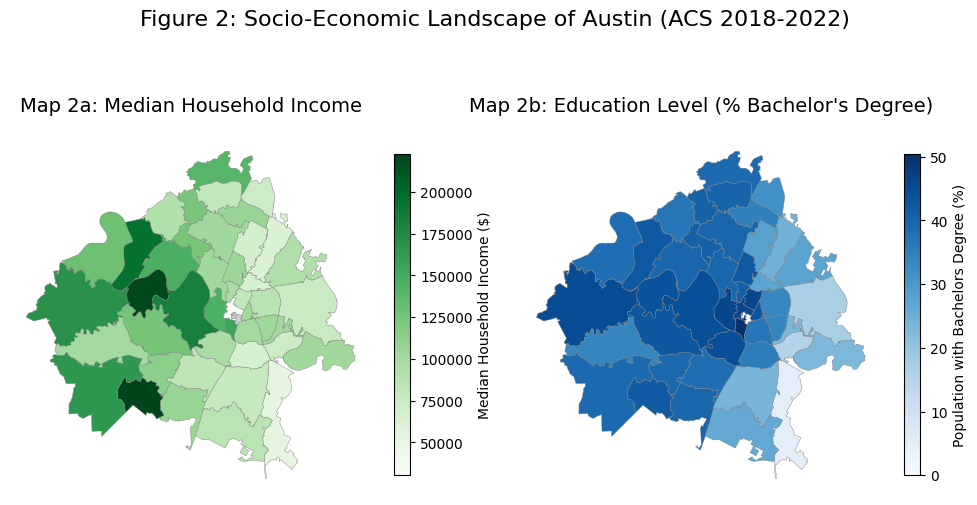

In [ ]:
#API
c = Census("1194d1d3af14452eb8aa96391f5925ed827b6fa6")

# Median Household Income: B19013_001E
# Education Numerator (Bachelor's Degree): B15003_022E
# Education Denominator (Population 25+): B15003_001E
target_vars = ['B19013_001E', 'B15003_001E', 'B15003_022E']

target_zips = austin_focus['ZCTA5CE20'].astype(str).unique().tolist()

# fetching data
census_data_list = []
# Split request to avoid API limits
for chunk in np.array_split(target_zips, 5):
    zips_str = ",".join(chunk)
    try:
        response = c.acs5.get(
            target_vars,
            geo={'for': f'zip code tabulation area:{zips_str}'}
        )
        census_data_list.extend(response)
    except Exception as e:
        print(f"Skipped chunk: {e}")

# df
census_df = pd.DataFrame(census_data_list)

# Renamed columns
census_df = census_df.rename(columns={
    'B19013_001E': 'Median_Income',
    'B15003_001E': 'Pop_25_Plus',
    'B15003_022E': 'Bachelors_Deg',
    'zip code tabulation area': 'ZCTA5CE20'
})

for col in ['Median_Income', 'Pop_25_Plus', 'Bachelors_Deg']:
    census_df[col] = census_df[col].astype(float)
    census_df[col] = census_df[col].where(census_df[col] >= 0, np.nan)

# calc %
census_df['Pct_Bachelors'] = (census_df['Bachelors_Deg'] / census_df['Pop_25_Plus']) * 100

austin_socio_map2 = austin_focus.merge(census_df, on='ZCTA5CE20', how='left')

fig, axes = plt.subplots(1, 2, figsize=(10,6))

# Map 2a: Median Household Income
austin_socio_map2.plot(
    column='Median_Income',
    cmap='Greens',
    legend=True,
    legend_kwds={'label': 'Median Household Income ($)', 'shrink': 0.6},
    edgecolor='grey',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=axes[0]
)
axes[0].set_title('Map 2a: Median Household Income', fontsize=14)
axes[0].axis('off')

# Map 2b: Education Level
austin_socio_map2.plot(
    column='Pct_Bachelors',
    cmap='Blues',
    legend=True,
    legend_kwds={'label': 'Population with Bachelors Degree (%)', 'shrink': 0.6},
    edgecolor='grey',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=axes[1]
)
axes[1].set_title('Map 2b: Education Level (% Bachelor\'s Degree)', fontsize=14)
axes[1].axis('off')

plt.suptitle("Figure 2: Socio-Economic Landscape of Austin", fontsize=16)
plt.tight_layout()
plt.show()

### 1.4.2 The Socio-Economic Landscape

In Figure 2, I explored the socio-economic context of Austin by mapping Median Household Income alongside Education Level. Looking at these maps side-by-side, I identified a stark divide between the East and West of the city. The Western areas, particularly the ‘Silicon Hills’, show significantly higher income levels and a much larger percentage of residents with bachelor's degrees. This makes sense, as the tech companies located here offer high salaries that attract graduates and incentivise them to settle in these affluent neighbourhoods.

In contrast, the Eastern side of Austin appears to remain the home of the city’s working class. I noticed that this area generally displays lower income and education levels, which aligns with the historical demographic make-up of the city, where [1] Hispanic and Black populations have traditionally lived in the East. This spatial pattern suggests a cyclical effect: wealthier families in the West can arguably afford university education, which leads to better-paying jobs, allowing them to maintain their status in these expensive areas. Meanwhile, despite Austin's overall growth, the benefits of the tech boom look to be concentrating heavily in the West, reinforcing this historical economic separation.

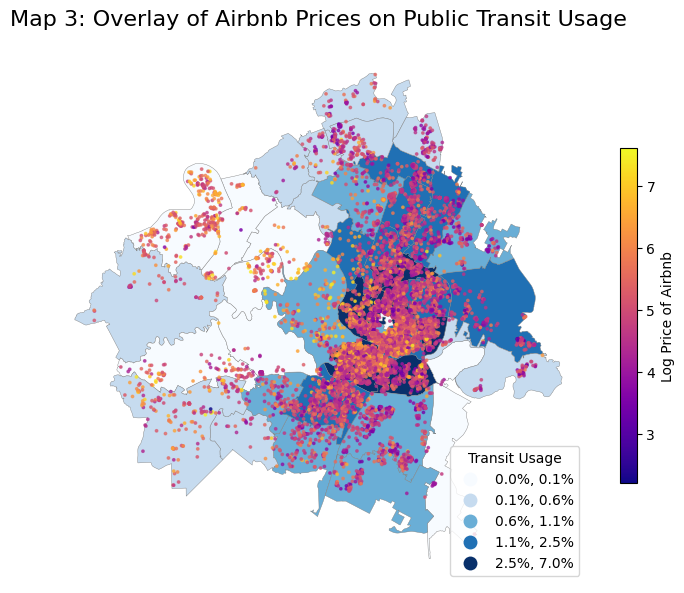

In [ ]:
c = Census("1194d1d3af14452eb8aa96391f5925ed827b6fa6")

target_vars = ['B08301_010E', 'B08301_001E']
target_zips = austin_focus['ZCTA5CE20'].astype(str).unique().tolist()

census_data_list = []
for chunk in np.array_split(target_zips, 5):
    zips_str = ",".join(chunk)
    try:
        response = c.acs5.get(
            target_vars,
            geo={'for': f'zip code tabulation area:{zips_str}'}
        )
        census_data_list.extend(response)
    except Exception as e:
        print(f"Skipped chunk: {e}")

# Create DataFrame
transit_df = pd.DataFrame(census_data_list)
transit_df = transit_df.rename(columns={
    'B08301_010E': 'Transit_Commuters',
    'B08301_001E': 'Total_Workers',
    'zip code tabulation area': 'ZCTA5CE20'
})

for col in ['Transit_Commuters', 'Total_Workers']:
    transit_df[col] = transit_df[col].astype(float)
    transit_df[col] = transit_df[col].where(transit_df[col] >= 0, np.nan)

transit_df['Pct_Transit'] = (transit_df['Transit_Commuters'] / transit_df['Total_Workers']) * 100

austin_transit_map = austin_focus.merge(transit_df, on='ZCTA5CE20', how='left')

# airbnb points
listings_clean['log_price'] = np.log(listings_clean['price_clean'])

fig, ax = plt.subplots(1, 1, figsize=(7,7))

# LAYER 1: POLYGONS (Public Transit Usage - Classified)
base = austin_transit_map.plot(
    column='Pct_Transit',
    scheme='Quantiles',
    k=5,
    cmap='Blues',
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower right', 'fmt': '{:.1f}%', 'title': 'Transit Usage'},
    edgecolor='grey',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

# LAYER 2: POINTS (Airbnb Log Price)
# We plot the points ON TOP
points = listings_clean.plot(
    column='log_price',
    cmap='plasma',
    ax=ax,
    markersize=3,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Log Price of Airbnb', 'shrink': 0.5}
)

# Formatting
ax.set_title("Map 3: Overlay of Airbnb Prices on Public Transit Usage", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()

### 1.4.3 Infrastructure & Accessibility: The ‘Tourist Bubble’

In Figure 3, I overlaid the price of Airbnbs (represented by dots) onto public transit usage to see if accessibility drives the market. The first thing I noticed was how surprisingly low transit usage is across Austin. Even in the ‘best’ connected areas, fewer than 7% of people use public transport to get to work. Compared to a city like London, where the tube and buses are vital to the city’s appeal, Austin feels fundamentally car-dependent. The only area with notable transit usage is the city centre, which I believe is likely due to tourists arriving without cars or locals wishing to avoid downtown traffic.

When I analysed the relationship between price and transit, I found almost no visual correlation. Expensive listings (yellow dots) are found in the transit-rich centre, but they are also abundant in the transit-poor West (‘Silicon Hills’). This suggests that while downtown tourists might use buses, the luxury market in the West relies entirely on private cars. Instead, the real correlation I saw was with *density*; the vast majority of listings cluster in these central transit zones. I also observed that while high-priced dominate the Centre and West, there are almost no expensive Airbnbs in the East, further reinforcing the economic divide I identified earlier.

Global Moran's I Value: 0.332
P-value: 0.002


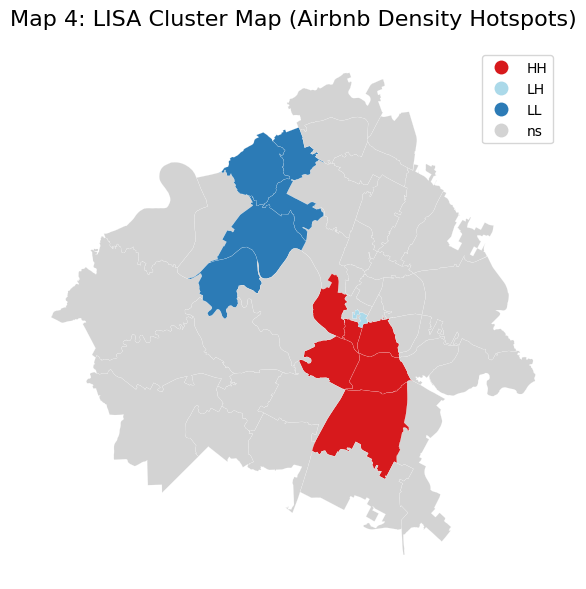

In [ ]:
austin_map_data['listing_count'] = austin_map_data['listing_count'].fillna(0)

# 'Queen' contiguity means any zipcodes that touch are neighbors.
w = libpysal.weights.Queen.from_dataframe(austin_map_data, use_index=False)

# Row-standardize the weights (essential for Moran's I)
w.transform = 'r'

# global moran's i
# This gives us one single number (0 to 1) for the whole city.
# > 0 means clustered, < 0 means dispersed, 0 means random.
y = austin_map_data['listing_count']
moran = Moran(y, w)
print(f"Global Moran's I Value: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")
# If p-value < 0.05, your result is statistically significant

lisa = Moran_Local(y, w)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# The 'lisa_cluster' function does all the heavy lifting for coloring
# It automatically colors High-High (Red), Low-Low (Blue), etc.
lisa_cluster(lisa, austin_map_data, p=0.05, ax=ax)

ax.set_title("Map 4: LISA Cluster Map (Airbnb Density Hotspots)", fontsize=16)
plt.tight_layout()
plt.show()

### 1.4.4 Statistical Verification: Local Moran's I

To verify if the patterns I observed were statistically significant, I performed a LISA analysis. The resulting Cluster Map (Figure 4) confirmed that the Airbnb market in Austin is highly polarised. I identified a distinct **High-High (red)** cluster covering the city centre and extending just south. This statistically proves the existence of the ‘tourist bubble’; activity here is so intense that it spills over into neighbouring zones, likely following the popular South Congress entertainment corridor.

In contrast, I observed a **Low-Low (blue)** cluster in the North West. This adds an important layer to my earlier analysis of the ‘Silicon Hills’. Although I previously found high *prices* in this area, this map confirms that the *density* of listings is statistically low. This suggests the wealthy western suburbs have successfully avoided the saturation seen downtown, maintaining a quieter residential character despite the high property values.

Perhaps most interestingly, I spotted a tiny **Low-High (light blue)** outlier right in the absolute centre of the High-High zone. This effectively creates an anomaly in the map. In real-world terms, this aligns perfectly with the State Capitol grounds and the University of Texas campus—large institutional zones with no private housing that are completely completely surrounded by the intense commercial pressure of the downtown rental market.

Loaded 32 Health Locations and 20864 Food Establishments.


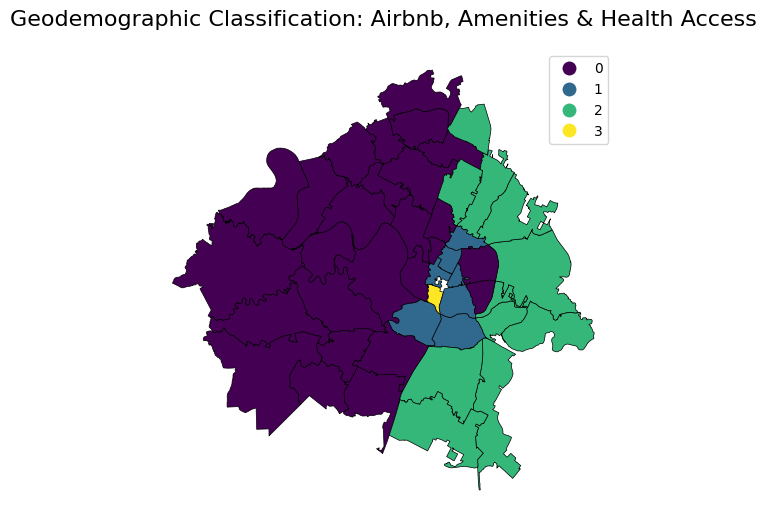


--- CLUSTER PROFILES (Average Values) ---
            Median_Income  Pct_Bachelors  Airbnb_Density  Food_Density  \
Cluster_ID                                                               
0           130067.320000      39.853619       19.538713     12.450013   
1            77761.285714      39.906181      143.188109     54.704468   
2            77201.800000      22.177099       10.686477      9.492110   
3           154867.000000      50.353288      508.550398    312.377394   

            Health_Density  
Cluster_ID                  
0                 0.011684  
1                 0.653945  
2                 0.033041  
3                 0.000000  


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#loading files
try:
    health_df = pd.read_csv("/content/drive/MyDrive/Data Science and AI/ENVS563/assignments/assignment 2 new/Austin_Public_Health_Locations_20251210.csv")
    food_df = pd.read_csv("/content/drive/MyDrive/Data Science and AI/ENVS563/assignments/assignment 2 new/Food_Establishment_Inspection_Scores_20251210.csv")
    print(f"Loaded {len(health_df)} Health Locations and {len(food_df)} Food Establishments.")
except FileNotFoundError as e:
    print(f"Error: Could not find file. Make sure it is uploaded! {e}")

# cleaning zips
def clean_zip(df, zip_col_name):
    # Convert to string, drop NaNs, extract first 5 digits
    df = df.dropna(subset=[zip_col_name]).copy()
    df['clean_zip'] = df[zip_col_name].astype(str).str.extract(r'(\d{5})')
    return df

# Apply cleaning
health_df = clean_zip(health_df, 'Zip Code')
food_df = clean_zip(food_df, 'Zip Code')

# counting
health_counts = health_df.groupby('clean_zip').size().reset_index(name='Health_Count')
# For food, we drop duplicates
unique_food = food_df.drop_duplicates(subset=['Restaurant Name', 'Address'])
food_counts = unique_food.groupby('clean_zip').size().reset_index(name='Food_Count')

# preparing geometry and data
# Start with your base shapefile
geo_df = austin_focus[['ZCTA5CE20', 'geometry']].to_crs("EPSG:2277")
geo_df['Area_SqMile'] = geo_df.area / 27878400

# Merge Census Data
geo_df = geo_df.merge(df_census, on='ZCTA5CE20', how='left')

# Merge New External Data
geo_df = geo_df.merge(health_counts, left_on='ZCTA5CE20', right_on='clean_zip', how='left')
geo_df = geo_df.merge(food_counts, left_on='ZCTA5CE20', right_on='clean_zip', how='left')

# Fill NaNs with 0
geo_df['Health_Count'] = geo_df['Health_Count'].fillna(0)
geo_df['Food_Count'] = geo_df['Food_Count'].fillna(0)

# Calculate Densities (Per Sq Mile)
geo_df['Health_Density'] = geo_df['Health_Count'] / geo_df['Area_SqMile']
geo_df['Food_Density'] = geo_df['Food_Count'] / geo_df['Area_SqMile']

# Add Airbnb Density
listings_counts = listings_clean.groupby('ZCTA5CE20').size().reset_index(name='Airbnb_Count')

geo_df['ZCTA5CE20'] = geo_df['ZCTA5CE20'].astype(str)
listings_counts['ZCTA5CE20'] = listings_counts['ZCTA5CE20'].astype(str)

geo_df = geo_df.merge(listings_counts, on='ZCTA5CE20', how='left')

geo_df['Airbnb_Count_y'] = geo_df['Airbnb_Count_y'].fillna(0)
geo_df['Airbnb_Density'] = geo_df['Airbnb_Count_y'] / geo_df['Area_SqMile']

#k means
features = [
    'Median_Income',    # Wealth
    'Pct_Bachelors',    # Class/Status
    'Airbnb_Density',   # The Market
    'Food_Density',     # Lifestyle
    'Health_Density'    # Public Services
]


data_for_clustering = geo_df.dropna(subset=features).copy()

# Scale
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering[features])

# K-Means (4 Clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
data_for_clustering['Cluster_ID'] = kmeans.fit_predict(data_scaled)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
final_map = data_for_clustering.plot(
    column='Cluster_ID',
    categorical=True,
    cmap='viridis',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
ax.set_title("Geodemographic Classification: Airbnb, Amenities & Health Access", fontsize=16)
ax.axis('off')
plt.show()

print("\n--- CLUSTER PROFILES (Average Values) ---")
print(data_for_clustering.groupby('Cluster_ID')[features].mean())

# Part 2: Multidimensional Geodemographic Classification

To generate a holistic typology of Austin's neighbourhoods, I applied a K-Means clustering algorithm to five variables: Median Income, Education, Airbnb Density, and two external datasets I sourced—**Food Establishment Density** and **Health Location Density**. I chose these external variables to distinguish between areas of ‘consumption’ (restaurants/bars) and areas of ‘civic function’ (hospitals/clinics).

The algorithm identified four distinct neighbourhood types (Table above) that reveal a stark spatial sorting. I found that **Cluster 3**, located in the absolute centre, represents the ‘Elite Experience Core’. It has the highest income (\$154k) and extreme Airbnb density (508 per sq mile), yet zero health services, suggesting a zone dedicated entirely to tourism and luxury consumption rather than residential living. In contrast, **Cluster 0** in the West (‘Silicon Hills’) represents ‘Quiet Wealth’. Despite having similarly high incomes ($130k), Airbnb density here is negligible (19.5), proving that wealthy suburban residents successfully insulate their neighbourhoods from the tourist economy.

Interestingly, **Cluster 1** (the wider centre) appears to be a ‘Civic Hub’, containing the highest density of health services. However, it also faces significant Airbnb pressure (143 per sq mile), suggesting a conflict between essential city functions and short-term rentals. Finally, **Cluster 2** in the East remains the most disconnected; with the lowest education levels and very low amenity density, it attracts almost no Airbnb investment, highlighting that the platform economy in Austin is strictly segregated into specific ‘lifestyle zones’.

# References
[1] A. Busch, “Building ‘A City of Upper-Middle-Class Citizens,’” Journal of Urban History, vol. 39, no. 5, pp. 975–996, Mar. 2013, doi: https://doi.org/10.1177/0096144213479324.

[2] R. W. Smilor, D. V. Gibson, and G. Kozmetsky, “Creating the technopolis: High-technology development in Austin, Texas,” Journal of Business Venturing, vol. 4, no. 1, pp. 49–67, Jan. 1989, doi: https://doi.org/10.1016/0883-9026(89)90033-5.